In [1]:
using FEM, Potential, PyPlot, Printf, JLD

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 50. # unit: angstrom
xavg = 50.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [14]:
sigma_kref = 5.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

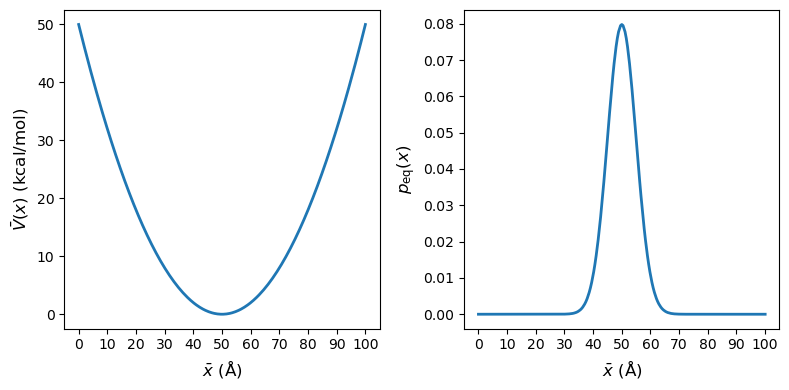

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$\\bar{x}\$ (Å)", fontsize=12)
ax.set_ylabel("\$\\bar{V}(x)\$ (kcal/mol)", fontsize=12)
ax.set_xticks(0:10:100)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$\\bar{x}\$ (Å)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(0:10:100)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_potential_peq_ps.pdf")
plt.show()

### Part 3: Langenvin dynamics simulations

In [34]:
# physical parameters
save_freq = 1 # unit: ps, Save trajectory per 1 ps
total_times = 10000 # unit: ps, totol simulate 50 ns
dt = 2e-3 # unit: ps  # Integration Times 2 fs #2e-3
D = 0.243; # Diffusion coefficient, unit: Å^2 ps-1
kbT = 0.593 # thermal energy, kcal/mol
D_div_kbT = D / kbT
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [37]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = 50. # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = force_harmonic_well_k_mean(ypos, kref, xavg)
        ypos = ypos +  D_div_kbT*dt*F + (dt*2*D)^(1/2) * randn() # because of quadratic variation, so put dt in the square root
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

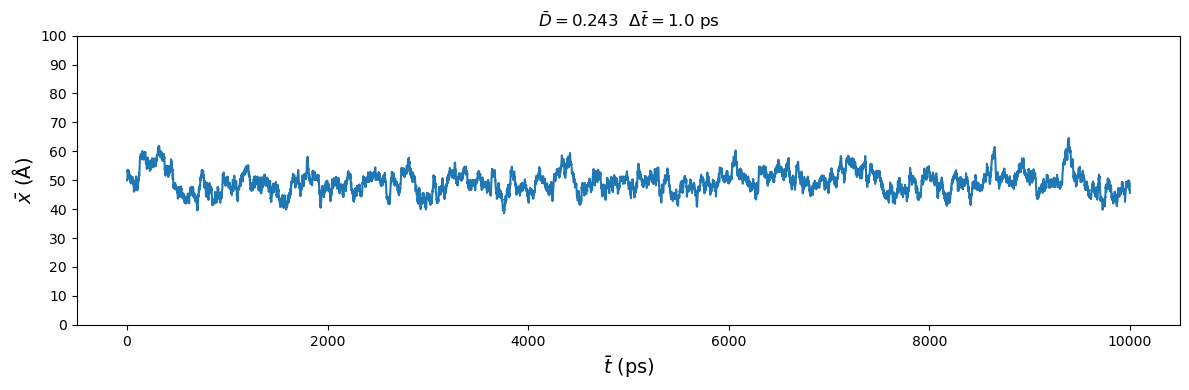

In [38]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("\$\\bar{x}\$ (Å)", fontsize=lbfz)
ax.set_xlabel("\$\\bar{t}\$ (ps)", fontsize=lbfz)
ax.set_title(@sprintf "\$ \\bar{D}=%.3f~~\\Delta \\bar{t}=%.1f\$ ps" D save_freq)
ax.set_yticks(0:10:100)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_potential_traj.pdf")
plt.show()

### Part 4: Save trajectory or Read trajectory

In [20]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_0_ps.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D, "k_ref", kref)

In [21]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_0_ps.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");